# AGD Lab Qualifcation Task 

In [1]:
from IPython.display import Image
url = 'http://crisp-dm.eu/wp-content/uploads/2013/07/newcrispdiagram.gif'
Image(url=url)

# 1. Data Adquisition

In [2]:
import pandas as pd

df_test = pd.read_csv('./data/test.csv', delimiter="|")
df_train = pd.read_csv('./data/train.csv', delimiter="|")

# 2. Business Case understanding

An established food retailer has introduced a self-scanning system that allows customers to scan their items using a handheld mobile scanner while shopping. This type of payment leaves retailers open to the risk that a certain number of customers will take advantage of this freedom to commit fraud by not scanning all of the items in their cart.

To minimize losses, the food retailer hopes to identify cases of fraud using targeted follow-up checks. The challenge here is to keep the number of checks as low as possible to avoid unnecessary added expense as well as to avoid putting off innocent customers due to false accusations. The objective  is to create a model to classify the scans as fraudulent or non-fraudulent. The classification does not take into account whether the fraud was committed intentionally or inadvertently. 

In addition to this general task, the retailer has defined his own domain specific costs outcomes for each possible prediction. This needs to be considered when evaluation possible prediction models.

- True Positive Cost: 5€
- False Positive Cost: -25 €
- True Negative Cost: 0€
- False Negative Cost: -5€

Thus, the retailer receives a profit of € 5 for every correctly identified fraud attempt (TP). However, for every fraud case that goes unexposed he loses € 5 (FN). A costumer falsely accused of fraud (FP), might not return to this store, which is denoted by a € 25 loss for the retailer. An honest customer identified (TN) correctly means neither profit nor loss for the retailer.

# 3. Data Understanding

In [3]:
df_train.sample(5)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
756,4,943,70.03,0,1,2,0.004242,0.074263,0.000000,0
1162,1,834,77.90,2,10,4,0.031175,0.093405,0.076923,1
1095,5,1308,15.42,10,4,1,0.019113,0.011789,0.400000,0
1653,5,1273,19.48,1,2,3,0.019639,0.015302,0.040000,0
1480,2,1765,85.29,8,5,3,0.011331,0.048323,0.400000,0


In the following, I will state a few core expects of the features. This is necessary to get a general feeling of the data and extract potential new features in the next step.

* **Trust Level** ~ A customers trust level rated between 1-6
* **Total scaned Item in sec** ~ total time in seconds between first and last product scanned
* **Grand total** ~ Total of products scanned
* **Line items voids** ~ Nr. of voided scanes
* **Scans without reg**~ Attempts to scan something without actually scanning something
* **Quantity Modification** ~ Number of modified quantities 
* **Scanned lined items per seconds** ~ Average number of scanned products
* **Value per send** ~ Average total value per second
* **Line items void per seconds** ~ Avg nr of item voids per total nr of all scanned and not canceled product
* **Fraud**~ Classification



# 4. Data Preperation

## 4.1 Data Cleaning

In [4]:
# 1. Checking data types
df_train.dtypes

trustLevel                     int64
totalScanTimeInSeconds         int64
grandTotal                   float64
lineItemVoids                  int64
scansWithoutRegistration       int64
quantityModifications          int64
scannedLineItemsPerSecond    float64
valuePerSecond               float64
lineItemVoidsPerPosition     float64
fraud                          int64
dtype: object

In [5]:
# 2. Checking if rows exists where cells are NaN
print("Number of NaN values:", len(df_train) - len(df_train.isna().any(axis=1)))

Number of NaN values: 0


The provided data of DMC 2019 seems as "clean" as a could be. All features have appropriate data types and no NaN value exists. Therefore, I will leave the data set as it is and continue with selecting and extracting appropriate features. After selecting and potentially generating new features, I will however consider detecting outliners.

## 4.2 Feature Extraction

In general, within a data set, there is many "hidden" information which needs to be explored by carefully looking at the data. Referring back to part 3 (Data Understanding), many possible interesting features can be generated. In the following steps I will try to enrich the data set by extracting potential values features. Their valuebility will afterwards be evaluated by measuring correlation with the output variable.

1. Extracting **total amount of items** by multiplying **"scannedLineItemsPerSecond"** with **"totalScanTimeInSeconds"**

In [6]:
df_train["totalItems"] = df_train["scannedLineItemsPerSecond"] * df_train["totalScanTimeInSeconds"]
df_test["totalItems"] = df_test["scannedLineItemsPerSecond"] * df_test["totalScanTimeInSeconds"]

2. Extracting **seconds per Euro** by multiplying **"grandTotal"** with **"scannedLineItems"**

In [7]:
df_train['secondsPerEuro'] = df_train['grandTotal'] / df_train['totalItems']
df_test['secondsPerEuro'] = df_test['grandTotal'] / df_test['totalItems']

In [8]:
# Swap target to last column (just for better Understandability...)
df_temp_1 = df_train.pop('totalItems') 
df_temp_2 = df_train.pop('fraud') 
df_train['totalItems']=df_temp_1 
df_train['fraud']=df_temp_2 

## 4.3 Feature Selection

Since not all features are relevant, I will filter irrelevant features out for my models. The filtering is applied using a correlation matrix (Pearson correlation). I will only select those features which have a correlation of above 0.02 (taking absolute value) with the output variable "**fraud**".

As we can see in the following, there are only a few features which we can classify as correlated. Most of the features are correlated around the notion of 0. Therefore, I will remove those features, which have practically no correlation, setting the absolute boundary at 0.02.

Furthermore, the extracted features **total items** and **seconds per euro** are comparable strongly correlated. Wuhu!

In the following code section, I will remove all non-relevant features given the above defined boundary.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

<Figure size 1200x1000 with 2 Axes>

In [10]:
cor_target = abs(cor["fraud"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.02]
relevant_features

trustLevel                   0.319765
totalScanTimeInSeconds       0.110414
lineItemVoids                0.063496
scansWithoutRegistration     0.074123
scannedLineItemsPerSecond    0.023085
valuePerSecond               0.028873
lineItemVoidsPerPosition     0.090116
secondsPerEuro               0.100765
totalItems                   0.298423
fraud                        1.000000
Name: fraud, dtype: float64

In [11]:
# Only keep relevant features
df_train = df_train[relevant_features.index.values] # Training Set
df_test = df_test[relevant_features.iloc[:-1].index.values] # Testing Set

## 4.4. Outlier Detection

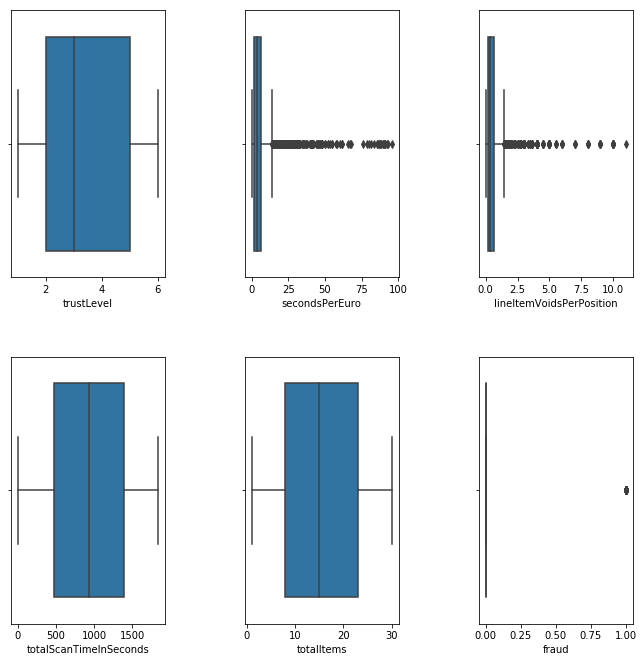

In [12]:
def plot_boxplots(df):
    fig, axs = plt.subplots(nrows=2, ncols=3,squeeze = True)
    fig.tight_layout()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    sns.boxplot(x=df['trustLevel'], ax=axs[0,0])
    sns.boxplot(x=df['totalScanTimeInSeconds'], ax=axs[1,0])
    sns.boxplot(x=df['lineItemVoidsPerPosition'], ax=axs[0,2])
    sns.boxplot(x=df['secondsPerEuro'],ax=axs[0,1])
    sns.boxplot(x=df['totalItems'], ax=axs[1,1])
    sns.boxplot(x=df['fraud'],ax=axs[1,2])
    
plot_boxplots(df_train)

In the following, I will remove the outliers in **'secondsPerEuro'** and **'LineItemVoidsPerPosition'**. This will be done by keeping only the rows that are within +3 to -3 standard deviations in the column **'LineItemVoidsPerPosition'** and **'secondsPerEuro'**.

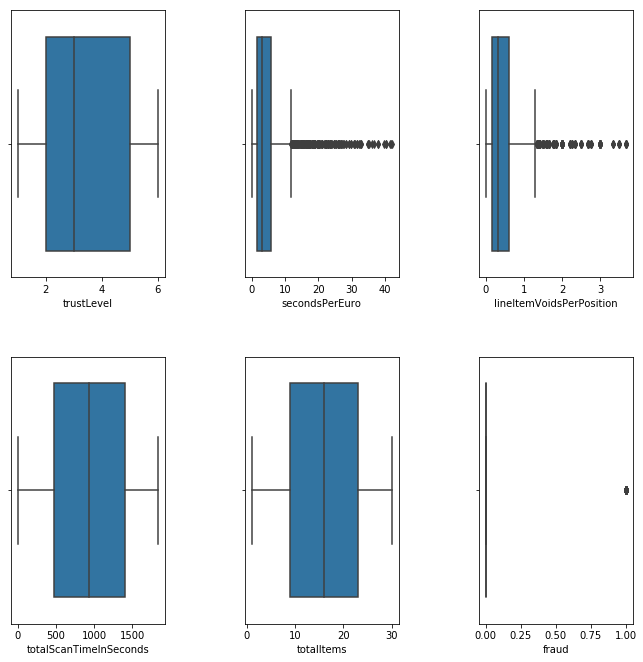

In [13]:
import numpy as np

# Training Set
df_train = df_train[np.abs(df_train.secondsPerEuro-df_train.secondsPerEuro.mean()) <= (3*df_train.secondsPerEuro.std())]
df_train = df_train[np.abs(df_train.lineItemVoidsPerPosition-df_train.lineItemVoidsPerPosition.mean()) <= (3*df_train.lineItemVoidsPerPosition.std())]

plot_boxplots(df_train)

## 4.5. Handling Imbalanced data using SMOTE

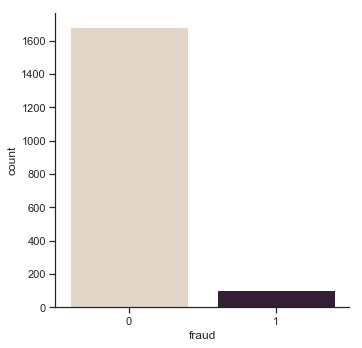

In [14]:
# Plotting Data Distribution
sns.set(style="ticks", color_codes=True)
sns.catplot(x="fraud", kind="count", palette="ch:.25", data=df_train);

As we can see, the data is highly imbalanced. This will require sample techniques such as SMOTE, Tomek Links, etc.: 
- oversampling the minority class
- undersampling the majority class.

Since the overall dataset is sufficient to train a model, it is unfortunately not sufficient to undersampling the majority class. Therefore, I will only consider oversampling methods of the minority class.

In the following, I will split the available data into test/evaluation and train sets before using sampling techniques! Sampling before splitting the data can allow the exact same observations to be present in both the test/evaluation and train sets. This can allow the model to simply memorize specific data points and cause overfitting and poor generalization to the test/evaluation data.

Since python provides a variety of packages, their are also multiple ways to apply oversampling techniques. I will  consider the SMOTE technique since this was also suggested in the appendix of this task.

### 4.5.1 Oversampling Minority class using SMOTE

In [16]:
import numpy as np
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning) # for readability purposes

X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns=['fraud']), df_train['fraud'], test_size=0.2, random_state=np.random.seed(1304)) 

sm = SMOTE(random_state=np.random.seed(1304), ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

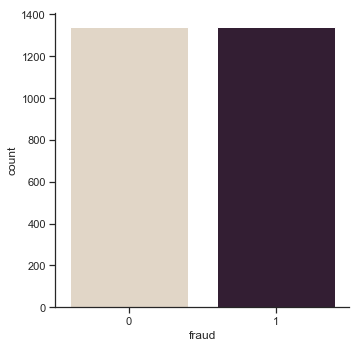

In [17]:
# check new class counts
sns.set(style="ticks", color_codes=True)
sns.catplot(x="fraud", kind="count", palette="ch:.25", data=pd.DataFrame(data=y_train, columns=['fraud']));

Besides using sampling techniques, we also need to consider appropriate evaluation metrics based on True/False Positives and Negatives such as:
- Precision
- Recall
- Domain-specific cost function

# 5. Modelling
## 5.1 General domain-specific consideration
### 5.1.1 Domain-specific costs

As in the data mining cup 2019 pdf-files states, evaluation need to consider cost in terms of prediction outcome:
- **True Positive** Cost: 5€
- **False Positive** Cost: -25 €
- **True Negative** Cost: 0€
- **False Negative** Cost: -5€

Thus, the retailer receives a profit of € 5 for every correctly identified fraud attempt (TP). However, for every fraud case that goes unexposed he loses € 5 (FN). A costumer falsely accused of fraud (FP), might not return to this store, which is denoted by a € 25 loss for the retailer. An honest customer identified (TN) correctly means neither profit nor loss for the retailer.

The sum of the costs or profit of all scans is the monetary value to be considered in the evaluation. Since predicting a fraud comes with considerable costs, it is important to be sensible in predicting Positives as a hole.

In the following, I will create two functions. One for calculating the domain specific cost, and one for plotting the confusion matrix.

In [18]:
from sklearn.metrics import confusion_matrix

def calc_domain_specific_metrics(y_true, y_pred):
    tp_cost = 5
    fp_cost = -25
    tn_cost = 0
    fn_cost = -5
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("Precision: \t\t", format(tp/(tp+fp), '.2f'))
    print("Recall: \t\t",  format(tp/(tp+fn), '.2f'))
    print("Domain Specific return: " , ((tp_cost*tp) + (fp_cost*fp) + (tn_cost*tn) + (fn_cost*fn)), '€')    
    
def calc_return_only(y_true, y_pred):
    tp_cost = 5
    fp_cost = -25
    tn_cost = 0
    fn_cost = -5
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return ((tp_cost*tp) + (fp_cost*fp) + (tn_cost*tn) + (fn_cost*fn))

### 5.1.2 Maximum Possible Profit
The best possible outcome in this task is the highest possible return. To measure  this we need the following
1. Training data's true targets: **y_train**
2. Domain specific return function: **calc_return_only**

Then we can compute the maximum possible return assuming we have predicted all outcomes correct:

In [19]:
print("Maximimum possible return in training spit:", calc_return_only(y_true=y_test, y_pred=y_test),"€")

Maximimum possible return in training spit: 80 €


In [20]:
print("Maximimum possible loss in training spit:", calc_return_only(y_true=y_test, y_pred=(~y_test.astype(bool)).astype(int)),"€")

Maximimum possible loss in training spit: -8630 €


Given the training set which I have splitting using random 80-20 split, we can achieve a profit within the boundaries of **[-8630€ : 80€]**. This means that there is "not much to win". Given this insight it will be important to be extremely careful and sensible in predicting positive fraud, since False Positive will result in huge profit loss.

 ### 5.1.3 Precision favoured over Recall

Given the above domain specific costs, we can see that we need to consider the trade-off between high precision, and high recall values. However, since False Positive is extremely costly for the retailers, and True Positives provides long-term profit benefits, I will prefer models with high precision score since precision is trying to minimize False Positive while maximizing True Positives. Thus, if precision is high, we can assume False Positives are low and True Positives are High.

Given the importance, the following function will be used for plotting a confusion matrix for every single model


In [38]:
from sklearn.metrics import plot_confusion_matrix

def plot_confusion_mat(X_test, y_test, cls, txt):
    title = "Confusion Matrix of " + txt
    disp = plot_confusion_matrix(cls, X_test, y_test,
                                     display_labels=['No Fraud', 'Fraud'],
                                     cmap=plt.cm.Blues,
                                     )
    disp.ax_.set_title(title)

    plt.show()

### 5.1.4 Algorithm considerations
Since our domain specific problem creates high costs from false predictions (in particular false positive) it is important to consider appropriate model design decisions. In general, no predefined classifier or solution exists for any problem (free lunch theorem). Two general approaches however can be considered for huge costs caused by false classification.

#### 1. Weight update scheme of algorithm
Since facing a supervised problem, the learning rate for the target variable can be set differently. In particular, setting the learning rate for fraud=1 higher compared to fraud=0 would increase sensibility towards predicting fraud.

#### 2. Optimal decision threshold
Another option to increase sensibility toward predicting fraud is setting a probability threshold. As mention above, we cannot gain much "profit" anyway (max = 80€). However, loosing profit can be achieved very fast (min = -8630€)

## 5.2 Modelling the Baseline: Naïve Bayes
Fundamentally, a baseline is a model that is both simple to set up and has a reasonable chance of providing decent results. Usually, a baseline model consists of relatively few trainable parameters and can be quickly fitted to the data without too much work. Using such a simple baseline, it is easier to identify where a simple baseline model fails for a given task and to make conclusions about where improvements are necessary. 

The Naïve Bayes classifier is simple to understand, fast to train, and only has a limited amount of hyperparameters to optimize. It is also one of the most straightforward yet most effective classification techniques.

In [39]:
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

In [40]:
cls_nb = pipeline.Pipeline([
    ('scal', StandardScaler()),
    ('clf', GaussianNB())
])

cls_nb = cls_nb.fit(X_train, y_train)
predY_nb = cls_nb.predict(X_test)

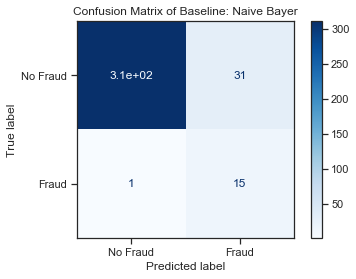

Precision: 		 0.33
Recall: 		 0.94
Domain Specific return:  -705 €


In [41]:
plot_confusion_mat(X_test, y_test, cls_nb, "Baseline: Naive Bayer")
calc_domain_specific_metrics(y_test, predY_nb)

The baseline model returns high recall score, low precision, and an overall negative return in the domain specific use case. The increase the precision, we need to find a way which is explicitly increasing precision. Precision increases if False Positives increases and/or True Negatives. Since we have a True Negative occurrence, we need to focus on the increasing True Positives. This will ultimately result in the reduction of costly False Positives.

One idea mentioned above is to modify the weights update scheme of an algorithm. One algorithm that can explicitly model weights classes is SVM with the *class_weight* parameter.


## 5.2 Weight update scheme of algorithm

### 5.2.1 Support Vector Machine - Weight configuration

SVM has two core advantages in our use case. It I san algorithm that can explicitly model weights classes with *class_weight* parameter and be can specify the level of sensibility towards misclassification using the hyperparameter *C*.

In [42]:
from sklearn.svm import SVC

cls_svm = pipeline.Pipeline([                          # Setting up Pipeline for SVM
    ('scale', StandardScaler()),
    ('clf', SVC(C=0.1, kernel='linear', class_weight={0:1.0, 1:2.0}, probability=True, random_state = np.random.seed(1304)))
])

In [43]:
cls_svm = cls_svm.fit(X_train, y_train)                # Train on training set
predY_svm = cls_svm.predict(X_test)                    # Predict on test set

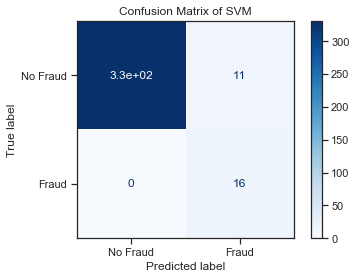

Precision: 		 0.59
Recall: 		 1.00
Domain Specific return:  -195 €


In [44]:
plot_confusion_mat(X_test, y_test, cls_svm, "SVM")
calc_domain_specific_metrics(y_test, predY_svm)

### 5.2.3 Random Forest - Weight configuration

In [45]:
from sklearn.ensemble import RandomForestClassifier

cls_rforest = pipeline.Pipeline([                           # Setting up Pipeline for RF
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight={0:1.0, 1:20.0}, n_estimators=10, random_state = np.random.seed(1304)))
])

In [46]:
cls_rforest = cls_rforest.fit(X_train, y_train)             # Train on training set
predY_rforest = cls_rforest.predict(X_test)                 # Predict on test set

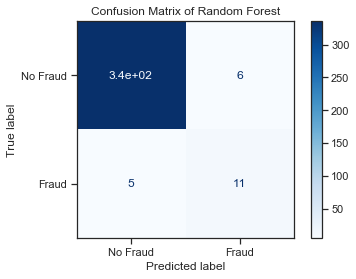

Precision: 		 0.65
Recall: 		 0.69
Domain Specific return:  -120 €


In [47]:
plot_confusion_mat(X_test, y_test, cls_rforest, "Random Forest")
calc_domain_specific_metrics(y_test, predY_rforest)

### 5.2.3 Logistic Regression - Weight configuration

In [48]:
from sklearn.linear_model import LogisticRegression
cls_LR = pipeline.Pipeline([                          # Setting up Pipeline for LR
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(C=1, class_weight={0:1.0, 1:1.0}, random_state = np.random.seed(1304)))
])

In [49]:
cls_LR = cls_LR.fit(X_train, y_train)                 # Train on training set
predY_LR = cls_LR.predict(X_test)                     # Predict on testing set

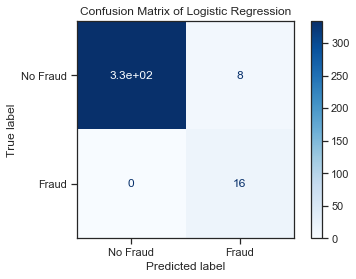

Precision: 		 0.67
Recall: 		 1.00
Domain Specific return:  -120 €


In [50]:
plot_confusion_mat(X_test, y_test, cls_LR, "Logistic Regression")
calc_domain_specific_metrics(y_test, predY_LR)

## 5.3 Optimal decision thresholds

My aim with threshold is to not just only build a general robust classifier, but a classifier which is optimized based on sensitivity towards predicting positives. The idea therefore is to the decision threshold to identify the best decision point. This basically means that I am trying to optimize domain specific costs while holding other parameters constant. 

In the following function, I will plot the consequences of different decision boundaries on the domain specific costs.

In [53]:
def compute_thresholds(clf):
    returns = []
    thresholds = []
    
    for threshold in np.logspace(0, 1, num=500, base=0.5):
        predicted_proba = clf.predict_proba(X_test)
        predicted = (predicted_proba [:,1] >= threshold).astype('int')
        returns.append(calc_return_only(y_test, predicted))
        thresholds.append(threshold)
        
    ax = sns.lineplot(x=thresholds, y=returns)
    ax.set(xlabel='Threshold', ylabel='Expected return in €', title='Threshold vs. Expected Return')

### 5.3.1 Support Vector Machines - decision thresholds

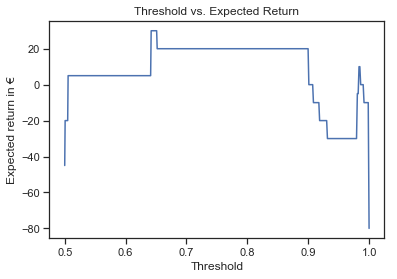

In [54]:
compute_thresholds(clf = cls_svm)

Hence, setting a threshold for probabilities **> ~0.8** will lead to positive + stable returns!

In [55]:
threshold = 0.8
predicted_proba = cls_svm.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

calc_domain_specific_metrics(y_test, predicted)

Precision: 		 0.88
Recall: 		 0.94
Domain Specific return:  20 €


### 5.3.2 Random Forest - decision thresholds

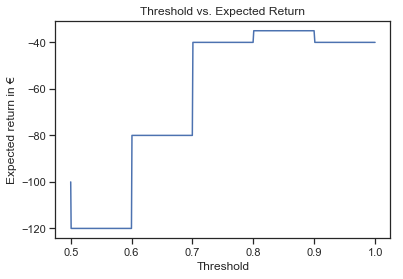

In [56]:
compute_thresholds(clf = cls_rforest)

Hence, setting a threshold for probabilities **> ~0.85** will lead to best returns! However negative!

In [57]:
threshold = 0.85
predicted_proba = cls_rforest.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

calc_domain_specific_metrics(y_test, predicted)

Precision: 		 0.88
Recall: 		 0.44
Domain Specific return:  -35 €


### 5.3.3 Logistic Regression - decision thresholds

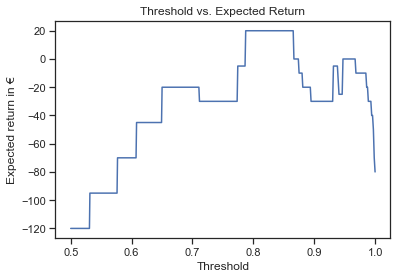

In [58]:
compute_thresholds(clf = cls_LR)

Hence, setting a threshold for probabilities **~0.9** will lead to best returns!

In [59]:
threshold = 0.9
predicted_proba = cls_LR.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

calc_domain_specific_metrics(y_test, predicted)

Precision: 		 0.83
Recall: 		 0.62
Domain Specific return:  -30 €


## 5.4 Hyperparameter Optimization and Cross Validation

### 5.4.1 SVM - GridSearchCV

In [60]:
from sklearn.model_selection import GridSearchCV

estimator_svm = pipeline.Pipeline([                                 # Setting up pipeline for SVM
    ('scale', StandardScaler()),
    ('clf', SVC(kernel='linear',gamma='auto', probability=True, random_state = np.random.seed(1304)))
])

param_grid_svm =  {                                                 # Setting up hyperparameter grid
    'clf__C' : np.logspace(0, 1, num=10, base=0.01),
    'clf__class_weight': [{0:w, 1:1} for w in [1, 2, 5, 10]],
    'clf__shrinking': [True, False],
}

In [61]:
cls_svm_grid = GridSearchCV(estimator_svm, param_grid_svm, cv=10, n_jobs=-1, verbose=1, refit='precision_score')
cls_svm_grid = cls_svm_grid.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   46.6s finished


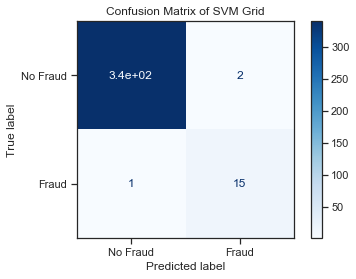

Precision: 		 0.88
Recall: 		 0.94
Domain Specific return:  20 €


In [62]:
predY_svm_grid = cls_svm_grid.predict(X_test)                   # Predict on test set
plot_confusion_mat(X_test, y_test, cls_svm_grid, "SVM Grid")    # Plot confusion matrix
calc_domain_specific_metrics(y_test, predY_svm_grid)            # compute domain return

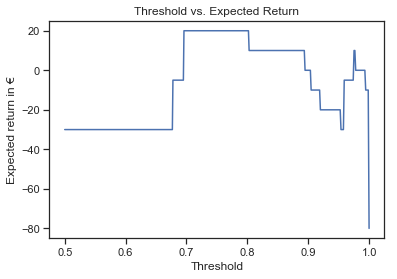

In [63]:
compute_thresholds(clf = cls_svm_grid)

In [64]:
threshold = 0.8
predicted_proba = cls_svm_grid.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

calc_domain_specific_metrics(y_test, predicted)

Precision: 		 0.88
Recall: 		 0.94
Domain Specific return:  20 €


### 5.4.2 Random Forest - GridSearchCV

In [65]:
estimator_rf = pipeline.Pipeline([
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state = np.random.seed(1304)))
])

param_grid_rf = {
    'clf__n_estimators' : [5, 10, 50],
    'clf__max_depth' : [None, 10, 20],
    'clf__class_weight': [{0:w, 1:1} for w in [1, 2, 5, 10]],
    'clf__ccp_alpha' : [0.0, 0.1, 0.2]
}

In [66]:
cls_rforest_grid = GridSearchCV(estimator_rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1, refit='precision_score')
cls_rforest_grid = cls_rforest_grid.fit(X_train, y_train)
predY_rforest_grid = cls_rforest_grid.predict(X_test)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   46.0s finished


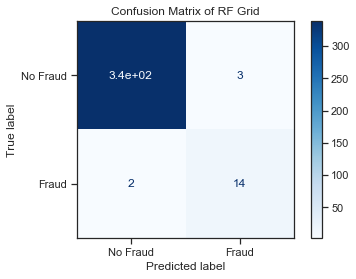

Precision: 		 0.82
Recall: 		 0.88
Domain Specific return:  -15 €


In [67]:
plot_confusion_mat(X_test, y_test, cls_rforest_grid, "RF Grid")
calc_domain_specific_metrics(y_test, predY_rforest_grid)

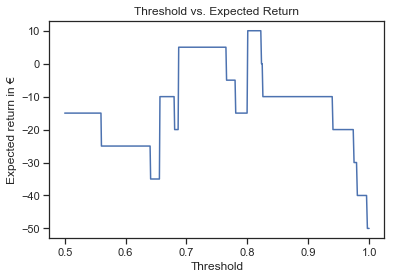

In [68]:
compute_thresholds(clf = cls_rforest_grid)

In [69]:
threshold = 0.85
predicted_proba = cls_rforest_grid.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

calc_domain_specific_metrics(y_test, predicted)

Precision: 		 1.00
Recall: 		 0.44
Domain Specific return:  -10 €


### 5.4.3 Logistic Regression - GridSearchCV

In [70]:
estimator_LR = pipeline.Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(random_state = np.random.seed(1304)))
])

param_grid_LR =  {
    'clf__C' : np.logspace(0, 1, num=10, base=0.01),
    'clf__class_weight': [{0:w, 1:1} for w in [1, 2, 5, 10]],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [71]:
cls_LR_grid = GridSearchCV(estimator_LR, param_grid_LR, cv=10, n_jobs=-1, verbose=1, refit='precision_score')
cls_LR_grid = cls_LR_grid.fit(X_train, y_train)
predY_LR_grid = cls_LR_grid.predict(X_test)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   46.6s finished


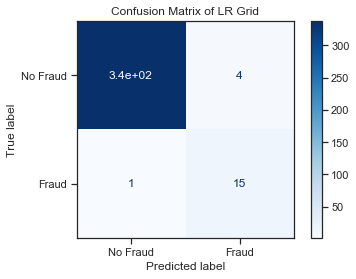

Precision: 		 0.79
Recall: 		 0.94
Domain Specific return:  -30 €


In [72]:
plot_confusion_mat(X_test, y_test, cls_LR_grid, "LR Grid")
calc_domain_specific_metrics(y_test, predY_LR_grid)

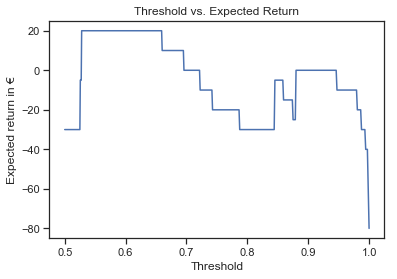

In [73]:
compute_thresholds(clf = cls_LR_grid)

In [74]:
threshold = 0.6
predicted_proba = cls_LR_grid.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

calc_domain_specific_metrics(y_test, predicted)

Precision: 		 0.88
Recall: 		 0.94
Domain Specific return:  20 €


## 5.4 Final Prediction using all data
For the final prediction I will use the Support Vector Machine model with CV, weighted classes, prediction threshold and tuned hyperparameters. This model gives a stabel tradeoff between precision and recall and generates a positive overall domain-specific return!

In [55]:
X_train, y_train = sm.fit_sample(df_train.drop(columns=['fraud']), df_train['fraud']) # Using all Data to train
X = df_test # For final prediciton

In [56]:
cls_svm_grid = GridSearchCV(estimator_svm, param_grid_svm, cv=10, n_jobs=-1, verbose=1, refit='precision_score')
cls_svm_grid = cls_svm_grid.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.1min finished


In [57]:
predY_final = cls_svm_grid.predict(X)                   # Predict on test set

In [58]:
# pd.DataFrame(predY_final, columns = ['fraud']).to_csv('./data/Justin_Lange-prediction.csv', index=False)

# 6. Summery
| Algorithm | Test in % | Train in % | CV | Hyperp. tuning |  Weight Config  | threshold | Precision | Recall | Domain-specific exp. return |
|:---------:|:---------:|:----------:|:---------------:|:------------------:|:---------------:|:------------------:|:---------:|:------:|:---------------------------:|
|     NB    |     80    |     20     |        -        |          -         |        -        |          -         |    .33    |   .94  |            -705€            |
|    SVM    |     80    |     20     |        -        |          -         |  {0:1.0, 1:2.0} |          -         |    .59    |   1.0  |            -195€            |
|     LR    |     80    |     20     |        -        |          -         |  {0:1.0, 1:1.0} |          -         |    .67    |   1.0  |            -120€            |
|     RF    |     80    |     20     |        -        |          -         | {0:1.0, 1:50.0} |          -         |    .85    |   .69  |             -120€            |
|    SVM    |     80    |     20     |        -        |          -         |  {0:1.0, 1:2.0} |        >0.8        |    .88    |   .94  |              20€             |
|     LR    |     80    |     20     |        -        |          -         |  {0:1.0, 1:1.0} |        >0.9        |    .83    |   .62  |             -30€            |
|     RF    |     80    |     20     |        -        |          -         | {0:1.0, 1:10.0} |        >0.65       |    1.0    |   .69  |             -70€             |
|    SVM    |     80    |     20     |     10 Fold     |         Yes        |  {0:1.0, 1:2.0} |        >0.8        |    .88    |   .94  |             20€             |
|     LR    |     80    |     20     |     10 Fold     |         Yes        |  {0:1.0, 1:1.0} |        >0.9        |    .88    |   .94  |             20€            |
|     RF    |     80    |     20     |     10 Fold     |         Yes        | {0:1.0, 1:10.0} |        >0.65       |     1.    |   .44  |             0€             |

### Final Remarks
The main goal of the retailer is to get more customers by a smoother shopping experience. This would eventually target more customers coming to the shop and therefore create higher revenue margins. 
This prediction model is however NOT a measurem about if this business model is worth it or not, but rather a question in what extend we should provide control towards possible theft. Therefore, the following remarks of this business setting can be concluded:
#### 1.	There is more to lose then to win
The prediction model required an extreme high precision rate with low False Positive rates. Implementing a prediction model which is not generalising properly could result in catastrophic effects in returning profits. A good generalised model would however only create small increasing profit margins. Therefore, it is necessary to question if we should provide such reactive approaches in general, but rather a proactive approach:

#### 2.	Proactive vs. reactive
Our model is a reactive approach based on the customers shopping pattern. Since there is much to lose in this reactive approach, it is reasonable to consider a proactive approach. An example of such proactive approach would be staff standing at the scan ensemble to monitor a bunch of scanners. This is a common approach in for common retailers too (IKEA) that provide self-service checkouts.

Furthermore, even if the retailer implements a reactive model which generates negative returns, it might still be useful if they would consider the costs of staff savings. Since a reactive approach requires staff which is constantly monitoring, it could be that a model which is generating negative return might generate overall savings if staff could therefore be reduced.